# Multi layer Perceptron

This project is based on the [AI for beginners](https://github.com/microsoft/AI-For-Beginners) course from microsoft and uses a similar framework to build the network, although the derivatives are calculated in a different way, following my own mathematical resolution of an N-layered perceptron, which can be seen in the pdf. 

For building a perceptron framework we will use 3 elements, in the form of classes:

    - Hidden layers
    - Output layers
    - A stackable network framework

Both layers will have a linear transformation forward pass, which outputs a transformation based on the weights and bias of the model. Then the hidden layer has an activation function forward pass which applies whatever activation function you choose to the layer, and the output layer has an activation function forward pass which is always a softmax to output probabilities. 
Both of them have a backward pass to calculate the derivatives of the weights and bias and an update method to update them.

The stackable network framework is the framework that allows us to stack multiple hidden layers and an output layer in our perceptron model and perform forward and backward passes on all of the layers automatically. 

The loss function is cross-entropy loss and the output layer uses a softmax activation function, since that is what I assumed for my mathematical resolution, but any hidden layer activation function can be used as long as the calculation of the derivative is added to the layer. In particular I will be using tanh since it is a simple function to differentiate. 

## Vector batches for SGD

MNIST digits are arrays of shape (784,)

To use SGD we will use a batch of input vectors instead of a single one. A batch of vectors is an array of shape (b,784)

The mathematical resolution was done using column vectors (784,) so this new row shape of the vectors requires us to transpose the matrix multiplications.
This involves changing the order and then transposing both vector and matrix (the vector is already transposed).

By changing the order of all terms and transposing the matrix at __init__ we achieve the same matrix multiplications, now with vectors of shape (,784) for forward and backward passes.

Now that we have the multiplication for row vectors, we have to accomodate for a batch of vectors. The result of a linear 
transformation of a batch is a matrix, where every row is the result of the transformation of one vector of the batch. The new bias needs to be a vector of shape (1,nout), where nout is the number of neurons in the next layer.

Vector-vector multiplication when changing to batch matrix-batch matrix multiplication is simply the sum of all pairs of vector vector multiplication. 
If the batch has 4 vectors, instead of (1,784) each vector is a matrix (4,784) and their multiplication is a sum over all 4 pairs of vector-vector multiplications. 
In the case of the bias, they don't sum themselves, the derivative of the bias is a (b,...) matrix so we must sum over axis=0 to obtain the proper shape.

This means that all operations can stay the same for a batch-batch multiplication as they were for a single vector when doing forward and backward passes.

In a batch of b vectors, the dimensions of the vectors for layer n are

Forward
 
    - input vector   (b,m(n-1))
    - Weights        (m(n-1),m(n))
    - bias           (1,m(n))
    - output         (b,m(n))

Backward

    - derivative activation  (b,m(n))
    - A coefficient          (b,m(n-1))
    - A "previous"(n+1)      (b,m(n))
    - Weights derivatives    (m(n-1),m(n))
    - bias derivatives       (b,m(n-1))

## Loading the dataset

In [25]:
import gzip
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.datasets import make_classification
# pick the seed for reproducibility
np.random.seed(0)
import random
import time
import os
from pathlib import Path
import time 

project_path = Path.cwd().parent
dataset = "mnist.pkl.gz"
dataset_path = project_path / "data" / dataset
#The mnist.pkl.gz file was donwloaded manually

with gzip.open(dataset_path, 'rb') as mnist_pickle:
    training_data, validation_data, test_data = pickle.load(mnist_pickle,encoding='latin1')



MNIST is a tuple containing a set of 50000 digits (train) and 2 sets of 10000 (validation and test).

MNIST[i][j][k]

    - i indicates train 0 validation 1 or test 2
    - j indicates array of digits 0 or labels 1
    - k indicates which digit or label 0-49999 0-9999

training_data[i][j]

    - i indicates array of digits 0 or labels 1
    - j indicates which digit or label 0-49999

Same for validation and test

## Framework

In [26]:
class Hidden_Layer():
    """Creates a hidden layer object.
    
    Args: 
			input_dimension: an integer indicating the number of nodes the layer takes as input
      output_dimension: an integer indicating the number of nodes the layer outputs
    """
    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (input_dimension,output_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def linear_forward(self,x):
        self.yn_1 = x                       
        return np.dot(x,self.W) + self.b    
    
    def activation_forward(self,z):
        y = np.tanh(z)
        self.da = 1-y*y                    
        return y                            
    
    def backward(self,A_prev):
        
        Ada = np.multiply(A_prev,self.da)
        
        self.dW = np.matmul(self.yn_1.T,Ada)
        self.db = Ada.sum(axis=0)

        return np.matmul(Ada,self.W.T)
        
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [27]:
class Output_Layer():
    """Creates an output layer object.
    
    Args: 
			input_dimension: an integer indicating the number of nodes the layer takes as input
      output_dimension: an integer indicating the number of nodes the layer outputs
    """
    def __init__(self,input_dimension,output_dimension):
        self.W = np.random.normal(0,1.0/np.sqrt(input_dimension), (input_dimension,output_dimension))
        self.b = np.zeros((1,output_dimension))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def linear_forward(self,x):
        self.yn_1 = x                       
        return np.dot(x,self.W) + self.b    
    
    def activation_forward(self,z):        
        zmax = z.max(axis=1,keepdims=True) #prevents overflow for big z values
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        self.p = expz / Z                   
        return self.p

    
    def backward(self,labels):        
        p_of_f = self.p
        for i,lab in enumerate(labels):
            p_of_f[i,lab] -= 1
        
        self.db = p_of_f.sum(axis=0)
        self.dW = np.matmul(self.yn_1.T,p_of_f)

        return np.matmul(p_of_f,self.W.T)
        
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [28]:
class Network:
    """Creates a Network to concatenate layers.
    
    Args: 
			None
    """
    def __init__(self):
        self.layers = []
        
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,y):
        for l in self.layers:          
            y = l.activation_forward(l.linear_forward(y))

        return y                
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

## Training a single layer perceptron

The first test we can do is create a simple 1 layer network and train it with a number of batches that covers our training set exactly once. This is sometimes known as a training epoch.

In [29]:
training_x = training_data[0]
print(training_x.shape)
training_labels = training_data[1]

net = Network()
#first layer gets training_x.shape[1] as input, output layer gets max(training_labels)+1 as output
net.add(Output_Layer(training_x.shape[1],max(training_labels)+1))

learning_rate = 0.01
batch_size = 10

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Initial accuracy for training data: ",acc)

for i in range(0,len(training_x),batch_size):
    xb = training_x[i:i+batch_size]
    yb = training_labels[i:i+batch_size]
    # forward pass
    p = net.forward(xb)
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Final accuracy for training data: ",acc)

(50000, 784)
Initial accuracy for training data:  0.0525
Final accuracy for training data:  0.90968


In [30]:
testing_x = test_data[0]
testing_labels = test_data[1]

pred = np.argmax(net.forward(testing_x),axis=1)
acc = (pred==testing_labels).mean()
print("Accuracy for testing data: ",acc)

Accuracy for testing data:  0.9099


## Training a multi layered perceptron



In [31]:
training_x = training_data[0]
training_labels = training_data[1]

net = Network()
#first layer gets training_x.shape[1] as input, output layer gets max(training_labels)+1 as output
#adding a layer with 10 nodes
#the output dimension for one layer and input dimension for the next must be the same
m = 40
n = 40
net.add(Hidden_Layer(training_x.shape[1],m))
net.add(Hidden_Layer(m,n))
net.add(Output_Layer(n,10))#max(training_labels)+1))

learning_rate = 0.01
batch_size = 10

pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Initial accuracy for training data: ",acc)

for i in range(0,len(training_x),batch_size):
    xb = training_x[i:i+batch_size]
    yb = training_labels[i:i+batch_size]
    # forward pass
    p = net.forward(xb)
    # backward pass
    net.backward(yb)
    net.update(learning_rate)
    
pred = np.argmax(net.forward(training_x),axis=1)
acc = (pred==training_labels).mean()
print("Final accuracy for training data: ",acc)

Initial accuracy for training data:  0.08648
Final accuracy for training data:  0.9454


In [32]:
testing_x = test_data[0]
testing_labels = test_data[1]

pred = np.argmax(net.forward(testing_x),axis=1)
acc = (pred==testing_labels).mean()
print("Accuracy for testing data: ",acc)

Accuracy for testing data:  0.9428


We can see the accuracy went up a bit from 0.9 to arround 0.94. The amount of nodes in the hidden layers play a significant role, a higher amount of nodes brings about higher accuracy, at the risk of overfitting.

# Building a Perceptron

Finally, we will build a better framework for our perceptron, simplifying the tasks of creating and training the network by creating a class that aoutomatically builds an N-layer perceptron when given a list of the number of nodes of every layer, including the input layer. Additionally, this class also has a function for training the model, which needs the training data and labels, learning rate, batch size and number of training epochs.  

This class also has a function that shows the accuracy of our model given a set of testing data, and offers the possibility of showing the confusion matrix and most mislabeled pair of digits, and a function to identify digits from an array.  

In [33]:
class Perceptron():
	"""Creates a perceptron model object.

	The input layer must be the same size as the flattened image, and the output layer must be the same size as
	the number of classes. The hidden layers can be any size, i.e [input,h1,h2,...,output] 

	Args: 
		layer_nodes_list: a list of integers, containig the number of nodes of every layer.
	"""

	def __init__(self,layer_nodes_list):  
			self.model = Network()
			if len(layer_nodes_list) > 2:
					for i in range(len(layer_nodes_list)-2):
							self.model.add(Hidden_Layer(layer_nodes_list[i],layer_nodes_list[i+1]))
					self.model.add(Output_Layer(layer_nodes_list[-2],layer_nodes_list[-1]))
			elif len(layer_nodes_list) == 2:
					self.model.add(Output_Layer(layer_nodes_list[0],layer_nodes_list[1]))
			else:
					print("Specify at least the number of nodes of the input and output layers")
	
	def train(self,training_x,training_labels,learning_rate,batch_size,n_epochs=1): 
		"""Train the model for a given number of epochs epoch. 
    
    Args:
      training_x: training data in numpy array format
      training_labels: training labels in numpy array format
      learning_rate: learning rate
      batch_size: batch size
	  	n_epochs: number of epochs 
    """
		for n in range(n_epochs):
			for i in range(0,len(training_x),batch_size):
					xb = training_x[i:i+batch_size]
					yb = training_labels[i:i+batch_size]
					# forward pass
					p = self.model.forward(xb)
					# backward pass
					self.model.backward(yb)
					self.model.update(learning_rate)
	
	def accuracy(self,testing_x,testing_labels,conf_mat_toggle=0):  
		"""Test the accuracy of a given model and make a confusion matrix. 
    
 	 	Args:
    	testing_x: testing data in numpy array format
    	testing_labels: testing labels in numpy array format
      conf_mat_toggle: if 1 displays a confusion matrix and the most mislabeled pairs
	  
  	Returns: 
			The accuracy of the model as float
  	"""
		pred = np.argmax(self.model.forward(testing_x),axis=1)
		acc = (pred==testing_labels).mean()
		#print(f"The accuracy of the model is {acc}")
		
		m = self.model.layers[-1].b.shape[1] #number of classes
		confusion_matrix = np.zeros((m,m))
		
		if conf_mat_toggle:
				for true_label,detected_label in zip(testing_labels,pred):
						if detected_label == true_label:
								confusion_matrix[int(detected_label),int(detected_label)] += 1
						else:
								confusion_matrix[int(detected_label),int(true_label)] += 1
				
				fig, ax = plt.subplots(1,1,figsize=(5,5)) 
				im=ax.matshow(confusion_matrix,aspect='auto')
				plt.title('Confusion matrix')
				plt.xlabel('true label')
				plt.ylabel('detected label')
				plt.show()
				max_conf = [0]
				conf_pairs = []
				N_max = 10
				N = confusion_matrix.sum()/100
				for i in range(m):
						for j in range(m):
								if i != j:
										if confusion_matrix[i,j]/N > max_conf[-1]:
												max_conf.append(confusion_matrix[i,j]/N)
												conf_pairs.append([i,j])
										elif confusion_matrix[i,j]/N > max_conf[0]:
												for n,k in enumerate(max_conf[1:]): 
														if confusion_matrix[i,j]/N < k:
																max_conf.insert(n+1,confusion_matrix[i,j]/N)
																conf_pairs.insert(n+1,[i,j])
																break
										if len(max_conf) > N_max:
												max_conf.pop(0)
												conf_pairs.pop(0)
				print(f"The accuracy of the model is {acc}")
				print('The',N_max,'most mislabeled pairs are:')
				for pair,perc in zip(list(reversed(conf_pairs)),list(reversed(max_conf))):
						print(pair,perc,'%')
				
		return acc
	
	
	def identify(self,digit):
			"""Identifies a digit
			
			Args: 
				digit: an image of a digit in numpy array format
			
			Returns:
                The digit the network identified
			"""
			p = self.model.forward(digit)
			return np.argmax(p)
	
	def clean(self):
			"""Deletes all the information stored in the model except for the weights, to save space when saving"""
			for l in range(len(self.model.layers[:-1])):
					for attr in ["dW","db","da","yn_1"]:
						try: 
							getattr(self.model.layers[l],attr)
							delattr(self.model.layers[l],attr)
						except AttributeError:
							pass
			for attr in ["dW","db","p","yn_1"]:
				try: 
						getattr(self.model.layers[-1],attr)
						delattr(self.model.layers[-1],attr)
				except AttributeError:
					pass


In [34]:
perc = Perceptron([784,20,20,10])

In [35]:
lr = 0.01
batch = 5
nepoch = 1
perc.train(training_data[0],training_data[1],lr,batch,nepoch)

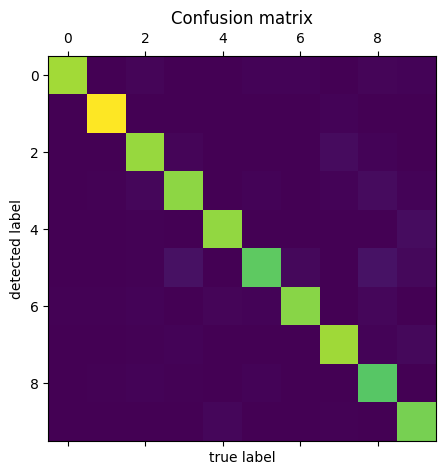

The accuracy of the model is 0.9305
The 10 most mislabeled pairs are:
[5, 8] 0.54 %
[5, 3] 0.52 %
[4, 9] 0.39 %
[3, 8] 0.33 %
[7, 9] 0.32 %
[5, 6] 0.26 %
[5, 9] 0.23 %
[3, 2] 0.22 %
[9, 4] 0.21 %


np.float64(0.9305)

In [36]:
perc.accuracy(test_data[0],test_data[1],1)

## Grid search

To fine-tune our model we will perform a grid search for the following hyperparameters:

    - learning rate
    - size of hidden layers
    - number of hidden layers 

We will assume that the number of epochs brings an increase in accuracy as the number of epochs increases regardless of 
the other parameters, so we will only try increasing number of epochs once we have found the best values for the rest of 
parameters, and we will stop once the accuracy plateaus.

In [37]:
def Grid_Search(parameters,training_data,training_labels,validation_data,validation_labels):
    """Performs a grid search, training the model with the given hyperparameters and comparing accuracy.
    
    Args: 
        parameters: dictionary with hyperparameter names as key and list of possible hyperparameter values as value
        training_data: training data
        training_labels: training labels 
        validation_data: validation data
        validation_labels: validation labels
    For example: 
        parameters = {'Learning_Rate': [0.1,0.01],
                        'Number of Hidden Layers': [0,1,2],
                        'Number of nodes in a hidden layer': [10,20,30]
                    }

    Returns: 
        A list of dictionaries, containing the hyperparameter values as key and accuracy as value.
    """
    
    accuracy = []
    
    inputlayer = [training_data.shape[1]]
    outputlayer = [max(training_labels)+1]
    for i,nhd in enumerate(parameters['Number of Hidden Layers']):
        accuracy.append({})
        #list of list with all the combinations of number of nodes for every hidden layer
        combinations = comb_rep_n(nhd,parameters['Number of nodes in a hidden layer'])
        for comb in combinations:
            layers = inputlayer + comb + outputlayer
            perc = Perceptron(layers)
            for lr in parameters['Learning_Rate']:
                batch = 5
                perc.train(training_data,training_labels,lr,batch,nepoch)
                acc = perc.accuracy(validation_data,validation_labels)
                accuracy[i].update( {'hidden layers:'+str(nhd)+':'+str(comb)+',lr:'+str(lr):acc} )
    return accuracy

def add_1_of_each(listoflists,listofnodes):
    """Takes a list of lists containing number of nodes and adds one of each in the list of number of nodes.
     
    Args: 
        listoflists: list of lists containing combinations of n number of nodes
        listofnodes: list containing the possible number of nodes to add to the combinations"""
    lol = []
    for li in listoflists:
        for m in range(len(listofnodes)):
            li.append(listofnodes[m])
            licopy = li[:]
            lol.append(licopy)
            li.pop(-1)
    return lol

def comb_rep_n(n,listofnodes):
    """Returns all possible combinations of n elements containing values from list of nodes
    
    Args: 
        n: integer dictating the number of elements of the combinations
        listofnodes: a list of integers containig the possible number of nodes to do the combinations
    
    Returns: 
        A list of lists"""
    comb=[[]]
    for k in range(n):
        comb = add_1_of_each(comb,listofnodes)
    return comb


The first set of hyperparameters we will use for a grid search are:

In [38]:
parameters = {'Learning_Rate': [0.0001,0.001,0.01,0.1],
              'Number of Hidden Layers': [0,1,2],
              'Number of nodes in a hidden layer': [10,20,40,60,80]
             }
#the total number of trials is 
#( sum_nhd (len(nn)^nhd) )* len(nlr)
#(5^0 + 5^1 + 5^2) * 4 = 124

In [39]:
#start = time.time()
#accuracy_dict = Grid_Search(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
#print('It took ', time.time()-start, ' seconds')

And now we will display the results of the grid search, separated based on the number of hidden layers, plotting the accuracy for every combination of numbers of nodes, with a different line for every learning rate. 

In [40]:
def disp_gs_results(accuracy_dict,lr_or_ne):
    """Displays the results of a grid search, as plots separated based on the number of hidden layers. The 
    accuracy is plotted for every combination of the number of nodes, with every line representing a different 
    learning rate or number of training epochs.
    
    Args: 
        accuracy_dict: a list of dictionaries containing the results of the grid search
        lr_or_ne: a string that is either 'lr' to plot different learning rates or 'ne' to plot different number 
        of epochs
    """

    L = len(accuracy_dict)
    nodes = []
    accuracy = []
    diflr = [] #named diflr but works for both lr and nepochs
    n_layers = []
    for h in range(L):
        nodes.append([])
        accuracy.append([])
        diflr.append([])
        for key in accuracy_dict[h].keys():
            spl = key.split(':')
            nhl = int(spl[1])
            if nhl not in n_layers:
                n_layers.append(nhl)
            num_nodes = spl[2][:-3]
            num_nodes = num_nodes.replace(",",",\n")
            accu = accuracy_dict[h][key]
            lr = float(spl[3])
            if lr not in diflr[h]:
                diflr[h].append(lr)
                nodes[h].append([])
                accuracy[h].append([])
            lridx = diflr[h].index(lr)
            nodes[h][lridx].append(num_nodes)
            accuracy[h][lridx].append(accu)

    fig, ax = plt.subplots(L,1,figsize=(15,15))
    for h in range(L):
        for i in range(len(diflr[h])):
            if lr_or_ne == 'lr':
                lab = "lr = "+str(diflr[h][i])
            if lr_or_ne == 'ne':
                lab = "n epochs = "+str(diflr[h][i])
            if n_layers[h] == 0:
                ax[h].plot(nodes[h][i], accuracy[h][i], marker = 'o', label = lab)
            else:
                ax[h].plot(nodes[h][i], accuracy[h][i], label = lab)    
        #ax[h].set_ylim([0,1])
        ax[h].set_title('Accuracy for '+str(n_layers[h])+' hidden layers')
        ax[h].set_xlabel('Nodes on the hidden layers')
        ax[h].set_ylabel('Accuracy')    
        ax[h].legend()
    plt.show()


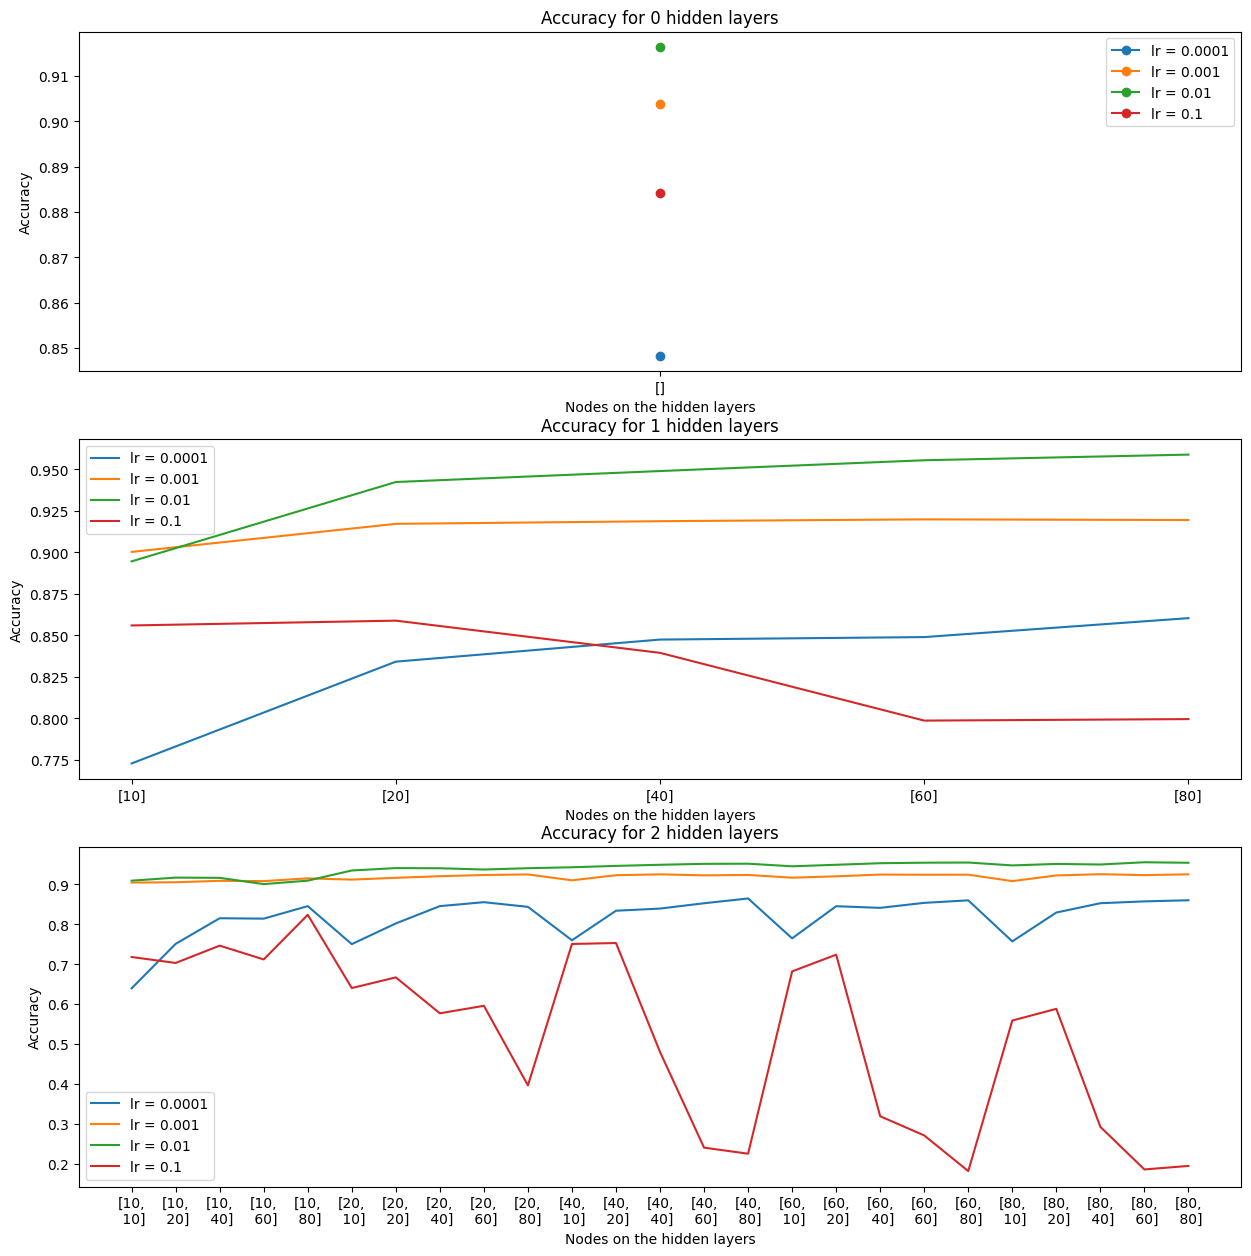

In [41]:
#import gs_2 for this example

grid = "gs_2.pkl"
grid_path = Path.cwd() / "grid_searches" / grid
with open(grid_path, 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'lr')


We can see in the graphs that
- the best learning rates are 0.01 and 0.001
- accuracy goes up with the number of nodes for 1 and 2 layers

But we would need a comparison between lr 0.01 for 0, 1 and 2 layers to see if the number of layers makes a difference 

In [ ]:
def compare_lr_ne(accuracy_dict,bestlr): #bestlr is a list of the best learning rate or n epochs for every number of layers
    """Plots a comparison of the accuracy for different number of layers given their best learning rates or number of 
    epochs.
    
    Args: 
        accuracy_dict: a list of dictionaries containing the results of the grid search
        bestlr: a list of the best learning rates used for the comparison or a list of the best number of epochs for
                each number of layers
    """
    L = len(accuracy_dict)
    nodes = []
    accuracy = []
    diflr = []
    n_layers = []
    for h in range(L):
        nodes.append([])
        accuracy.append([])
        diflr.append([])
        for key in accuracy_dict[h].keys():
            spl = key.split(':')
            nhl = int(spl[1])
            if nhl not in n_layers:
                n_layers.append(nhl)
            num_nodes = spl[2][:-3]
            num_nodes = num_nodes.replace(",",",\n")
            accu = accuracy_dict[h][key]
            lr = float(spl[3])
            if lr not in diflr[h]:
                diflr[h].append(lr)
                nodes[h].append([])
                accuracy[h].append([])
            lridx = diflr[h].index(lr)
            nodes[h][lridx].append(num_nodes)
            accuracy[h][lridx].append(accu)

    fig, ax = plt.subplots(1,1,figsize=(12,6))
    for h,maxlr in zip(range(L),bestlr):
        i = diflr[h].index(maxlr)
        xdummy = np.linspace(0,100,len(nodes[h][i]))
        if n_layers[h] == 0:
            ax.plot(xdummy, accuracy[h][i], marker = 'o', label = "number of layers = "+str(n_layers[h]))    
        else:
            ax.plot(xdummy, accuracy[h][i], label = "number of layers = "+str(n_layers[h]))    
    #ax.set_ylim([0,1])
    ax.set_title('Accuracy for the highest lr or epoch')
    ax.set_xlabel('no units')
    ax.set_ylabel('Accuracy')    
    ax.legend()
    plt.show()

In [43]:
def print_best_models(accuracy_dict):
    #prints the model with the higher accuracy for every line
    """Prints the model with the highest accuracy for every learning rate or number of epochs among all different
    number of layers and number of nodes.
    
    Args: 
        accuracy_dict: a list of dictionaries containing the results of the grid search
    """
    L = len(accuracy_dict)
    nodes = []
    accuracy = []
    diflr = []
    n_layers = []
    for h in range(L):
        nodes.append([])
        accuracy.append([])
        diflr.append([])
        for key in accuracy_dict[h].keys():
            spl = key.split(':')
            nhl = int(spl[1])
            if nhl not in n_layers:
                n_layers.append(nhl)
            num_nodes = spl[2][:-3]
            #num_nodes = num_nodes.replace(",",",\n")
            accu = accuracy_dict[h][key]
            lr = float(spl[3])
            if lr not in diflr[h]:
                diflr[h].append(lr)
                nodes[h].append([])
                accuracy[h].append([])
            lridx = diflr[h].index(lr)
            nodes[h][lridx].append(num_nodes)
            accuracy[h][lridx].append(accu)

    for h in range(L):
        for lrid in range(len(diflr[h])):
            nid = accuracy[h][lrid].index(max(accuracy[h][lrid]))
            print('lr or ne',diflr[h][lrid],'hidden layer nodes',nodes[h][lrid][nid],'accuracy',max(accuracy[h][lrid]))

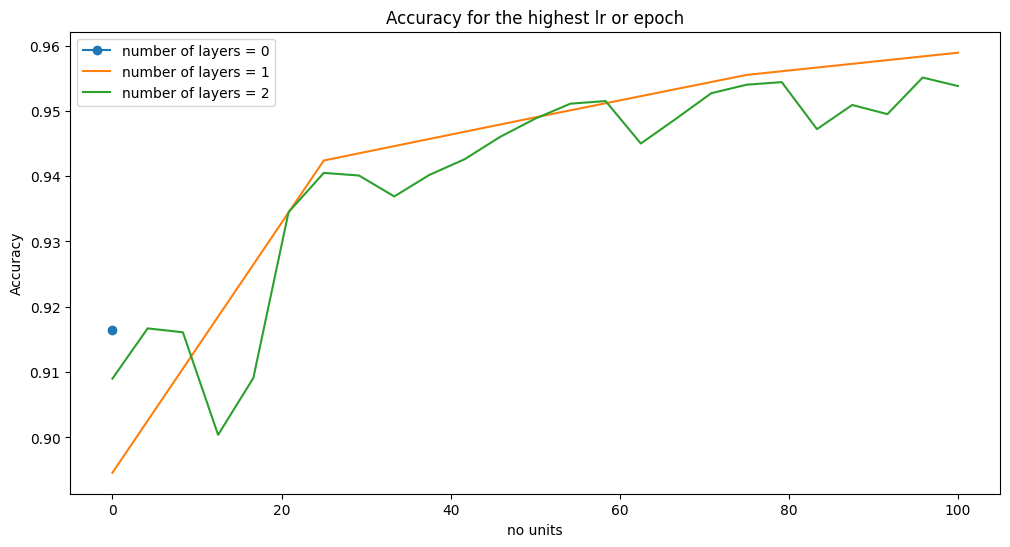

In [44]:
#import gs_2 for this example
compare_lr_ne(accuracy_dict,[0.01,0.01,0.01])

In [46]:
print_best_models(accuracy_dict)

lr or ne 0.0001 hidden layer nodes [] accuracy 0.8483
lr or ne 0.001 hidden layer nodes [] accuracy 0.9038
lr or ne 0.01 hidden layer nodes [] accuracy 0.9164
lr or ne 0.1 hidden layer nodes [] accuracy 0.8842
lr or ne 0.0001 hidden layer nodes [80] accuracy 0.8604
lr or ne 0.001 hidden layer nodes [60] accuracy 0.9199
lr or ne 0.01 hidden layer nodes [80] accuracy 0.9589
lr or ne 0.1 hidden layer nodes [20] accuracy 0.8589
lr or ne 0.0001 hidden layer nodes [40, 80] accuracy 0.8645
lr or ne 0.001 hidden layer nodes [80, 40] accuracy 0.9252
lr or ne 0.01 hidden layer nodes [80, 60] accuracy 0.9551
lr or ne 0.1 hidden layer nodes [10, 80] accuracy 0.8236


We can see that for both 1 and 2 layers the accuracy is similar, and 0 layers performs worse, as expected. Moreover it still increases when the number of nodes increases,  so we will try another grid search, this time with:
- 1, 2, 3 hidden layers.  Since 1 and 2 performed similarly we want to see what happens when we add more layers
- more nodes on the hidden layers, since accuracy was directly proportional to the number of nodes, starting from 80
- learning rates closer to 0.01 and 0.001 since they perform the best

Now the parameters look like

In [48]:
parameters = {'Learning_Rate': [0.001,0.005,0.01,0.05],
              'Number of Hidden Layers': [1,2,3],
              'Number of nodes in a hidden layer': [80,100,120]
             }
#the total number of trials is 
#( sum_nhd (len(nn)^nhd) )* len(nlr)
#(3^1 + 3^2 + 3^3) * 4 = 156

In [49]:
#start = time.time()
#accuracy_dict = Grid_Search(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
#print('It took ', time.time()-start, ' seconds')

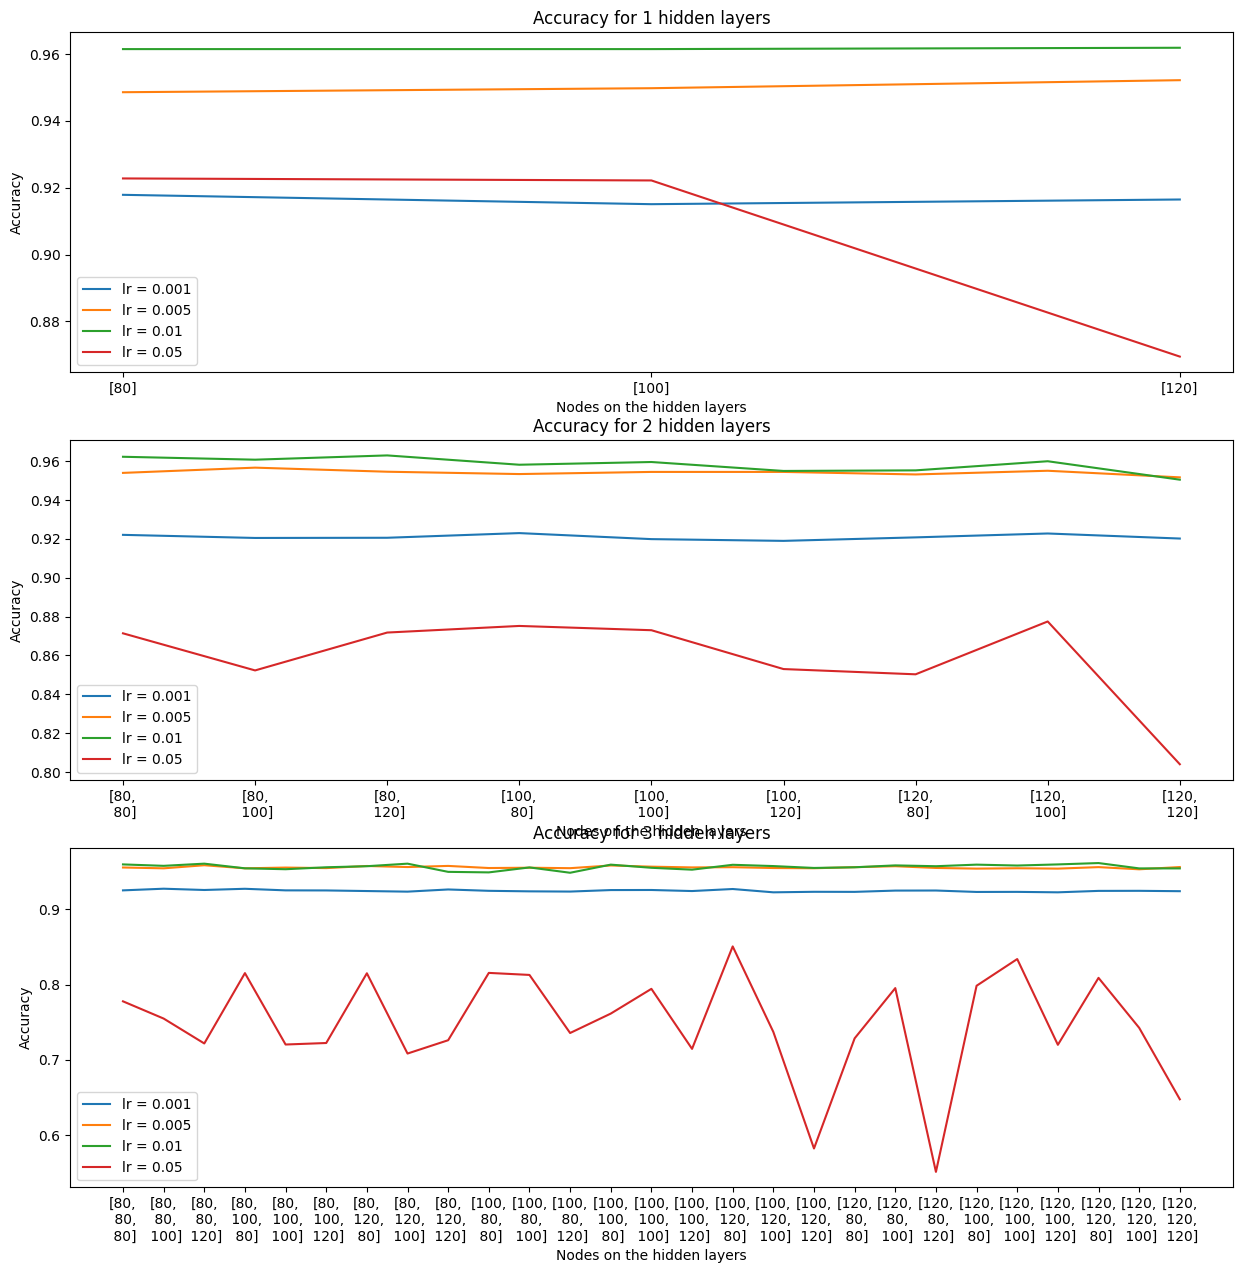

In [52]:
#import gs_3 for this example

grid = "gs_3.pkl"
grid_path = Path.cwd() / "grid_searches" / grid
with open(grid_path, 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'lr')

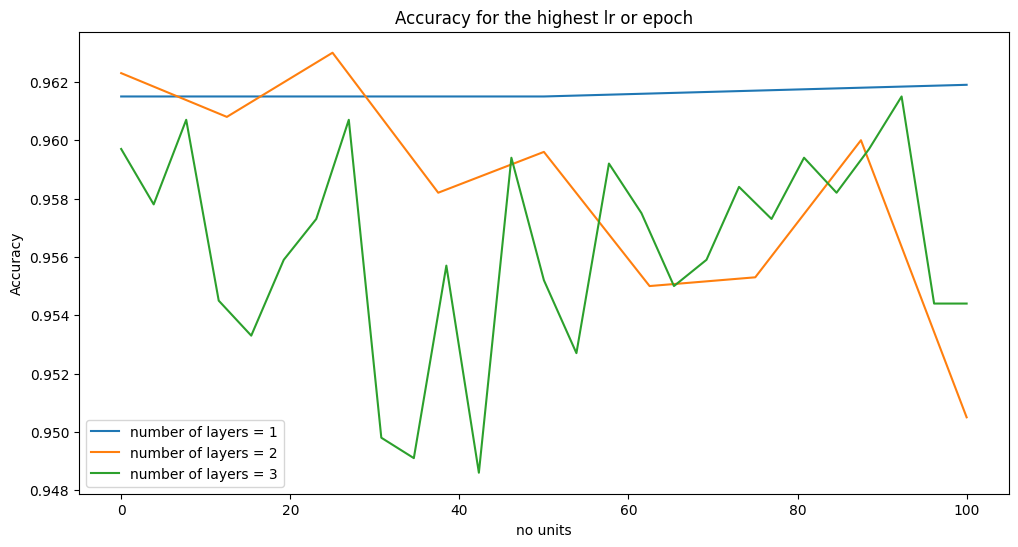

In [53]:
#gs_3
compare_lr_ne(accuracy_dict,[0.01,0.01,0.01])

This seems to indicate, somewhat counterintuitively, that the accuracy of the model doesn't go up as the number of layers goes up, and it instead diminishes.

However this results were obtained with only a max of 120 nodes per hidden layer and using only 1 training epoch. 
Changing the number of training epochs might be important for networks with more layers, so it will be our next pursuit. 
Initially, we assumed the number of epochs affected the performance of the model equally for all structures, but these results might indicate otherwise, so now we will add the number of training epochs as a hyperparameter in the gridsearch. 

But first we will look at our current best models.

In [54]:
#gs_3
print_best_models(accuracy_dict)

lr or ne 0.001 hidden layer nodes [80] accuracy 0.9179
lr or ne 0.005 hidden layer nodes [120] accuracy 0.9522
lr or ne 0.01 hidden layer nodes [120] accuracy 0.9619
lr or ne 0.05 hidden layer nodes [80] accuracy 0.9228
lr or ne 0.001 hidden layer nodes [100, 80] accuracy 0.923
lr or ne 0.005 hidden layer nodes [80, 100] accuracy 0.9567
lr or ne 0.01 hidden layer nodes [80, 120] accuracy 0.963
lr or ne 0.05 hidden layer nodes [120, 100] accuracy 0.8775
lr or ne 0.001 hidden layer nodes [80, 80, 100] accuracy 0.9274
lr or ne 0.005 hidden layer nodes [80, 80, 120] accuracy 0.9586
lr or ne 0.01 hidden layer nodes [120, 120, 80] accuracy 0.9615
lr or ne 0.05 hidden layer nodes [100, 120, 80] accuracy 0.8507


We can see the best models are
- \[80,120] lr = 0.01 for an accuracy of 0.963 
- \[120] lr = 0.01 for an accuracy of 0.9619
- \[120,120,80] lr = 0.01 for an accuracy of 0.9615

This shows that 0.01 is the best learning rate we have tried yet and that the number of layers is not very relevant at least for number of nodes in the 80-120 range and 1 training epoch.

Now we will do the next grid search, this time adding a new parameter n_epochs. For simplicity we will be doing another grid search function that assumes the learning rate to be a constant and has the number of epochs as a hyperparameter since otherwise it would be hard to iterate and visualize the results. 

We can still use the same visualization functions as long as we change the labels accordingly. 

In [55]:
def Grid_Search(parameters,training_data,training_labels,validation_data,validation_labels):
    """Performs a grid search, training the model with the given hyperparameters and comparing accuracy.
    
    Args: 
        parameters: dictionary with hyperparameter names as key and list of possible hyperparameter values as value
        training_data: training data
        training_labels: training labels 
        validation_data: validation data
        validation_labels: validation labels
    For example: 
        parameters = {'Learning_Rate': [0.1,0.01],
                        'Number of Hidden Layers': [0,1,2],
                        'Number of nodes in a hidden layer': [10,20,30]
                    }

    Returns: 
        A list of dictionaries, containing the hyperparameter values as key and accuracy as value.
    """
    
    accuracy = []
    
    inputlayer = [training_data.shape[1]]
    outputlayer = [max(training_labels)+1]
    for i,nhd in enumerate(parameters['Number of Hidden Layers']):
        accuracy.append({})
        #list of list with all the combinations of number of nodes for every hidden layer
        combinations = comb_rep_n(nhd,parameters['Number of nodes in a hidden layer'])
        for comb in combinations:
            layers = inputlayer + comb + outputlayer
            perc = Perceptron(layers)
            for lr in parameters['Learning_Rate']:
                batch = 5
                perc.train(training_data,training_labels,lr,batch,nepoch)
                acc = perc.accuracy(validation_data,validation_labels)
                accuracy[i].update( {'hidden layers:'+str(nhd)+':'+str(comb)+',lr:'+str(lr):acc} )
    return accuracy

def add_1_of_each(listoflists,listofnodes):
    """Takes a list of lists containing number of nodes and adds one of each in the list of number of nodes.
     
    Args: 
        listoflists: list of lists containing combinations of n number of nodes
        listofnodes: list containing the possible number of nodes to add to the combinations"""
    lol = []
    for li in listoflists:
        for m in range(len(listofnodes)):
            li.append(listofnodes[m])
            licopy = li[:]
            lol.append(licopy)
            li.pop(-1)
    return lol

def comb_rep_n(n,listofnodes):
    """Returns all possible combinations of n elements containing values from list of nodes
    
    Args: 
        n: integer dictating the number of elements of the combinations
        listofnodes: a list of integers containig the possible number of nodes to do the combinations
    
    Returns: 
        A list of lists"""
    comb=[[]]
    for k in range(n):
        comb = add_1_of_each(comb,listofnodes)
    return comb


In [56]:
def Grid_Search_epoch(parameters,training_data,training_labels,validation_data,validation_labels):
    """Performs a grid search, training the model with the given hyperparameters and comparing accuracy.

    This grid search adds another hyperparameter, number of epochs, and takes a fixed learning rate.
    
    Args: 
        parameters: dictionary with hyperparameter names as key and list of possible hyperparameter values as value
        training_data: training data
        training_labels: training labels 
        validation_data: validation data
        validation_labels: validation labels
    For example: 
        parameters = {'Learning_Rate': 0.01
                    'Number of  training epochs': [1,2,3],
                    'Number of Hidden Layers': [4,5,6],
                    'Number of nodes in a hidden layer': [7,8,9]
                    }

    Returns: 
        A list of dictionaries, containing the hyperparameter values as key and accuracy as value.
    """

    
    accuracy = []
    
    inputlayer = [training_data.shape[1]]
    outputlayer = [max(training_labels)+1]
    
    lr = parameters['Learning_Rate']

    for i,nhd in enumerate(parameters['Number of Hidden Layers']):
        accuracy.append({})
        #list of list with all the combinations of number of nodes for every hidden layer
        combinations = comb_rep_n(nhd,parameters['Number of nodes in a hidden layer'])
        for comb in combinations:
            layers = inputlayer + comb + outputlayer
            perc = Perceptron(layers)
            for nepoch in parameters['Number of  training epochs']:
                batch = 5
                perc.train(training_data,training_labels,lr,batch,nepoch)
                acc = perc.accuracy(validation_data,validation_labels)
                accuracy[i].update( {'hidden layers:'+str(nhd)+':'+str(comb)+',ep:'+str(nepoch):acc} )
    return accuracy

Now we can perform our new grid search with parameters

In [57]:
parameters = {'Learning_Rate': 0.01,
              'Number of  training epochs': [1,2,3],
              'Number of Hidden Layers': [1,2,3],
              'Number of nodes in a hidden layer': [80,100,120]
             }
#the total number of trials is      (assuming 1 epoch 1 trial, 2 epochs 2 trials)
#( sum_nhd (len(nn)^nhd) )* sum(nte)
#(3^1 + 3^2 + 3^3) * 6 = 234

In [58]:
#start = time.time()
#accuracy_dict = Grid_Search_epoch(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
#print('It took ', time.time()-start, ' seconds')

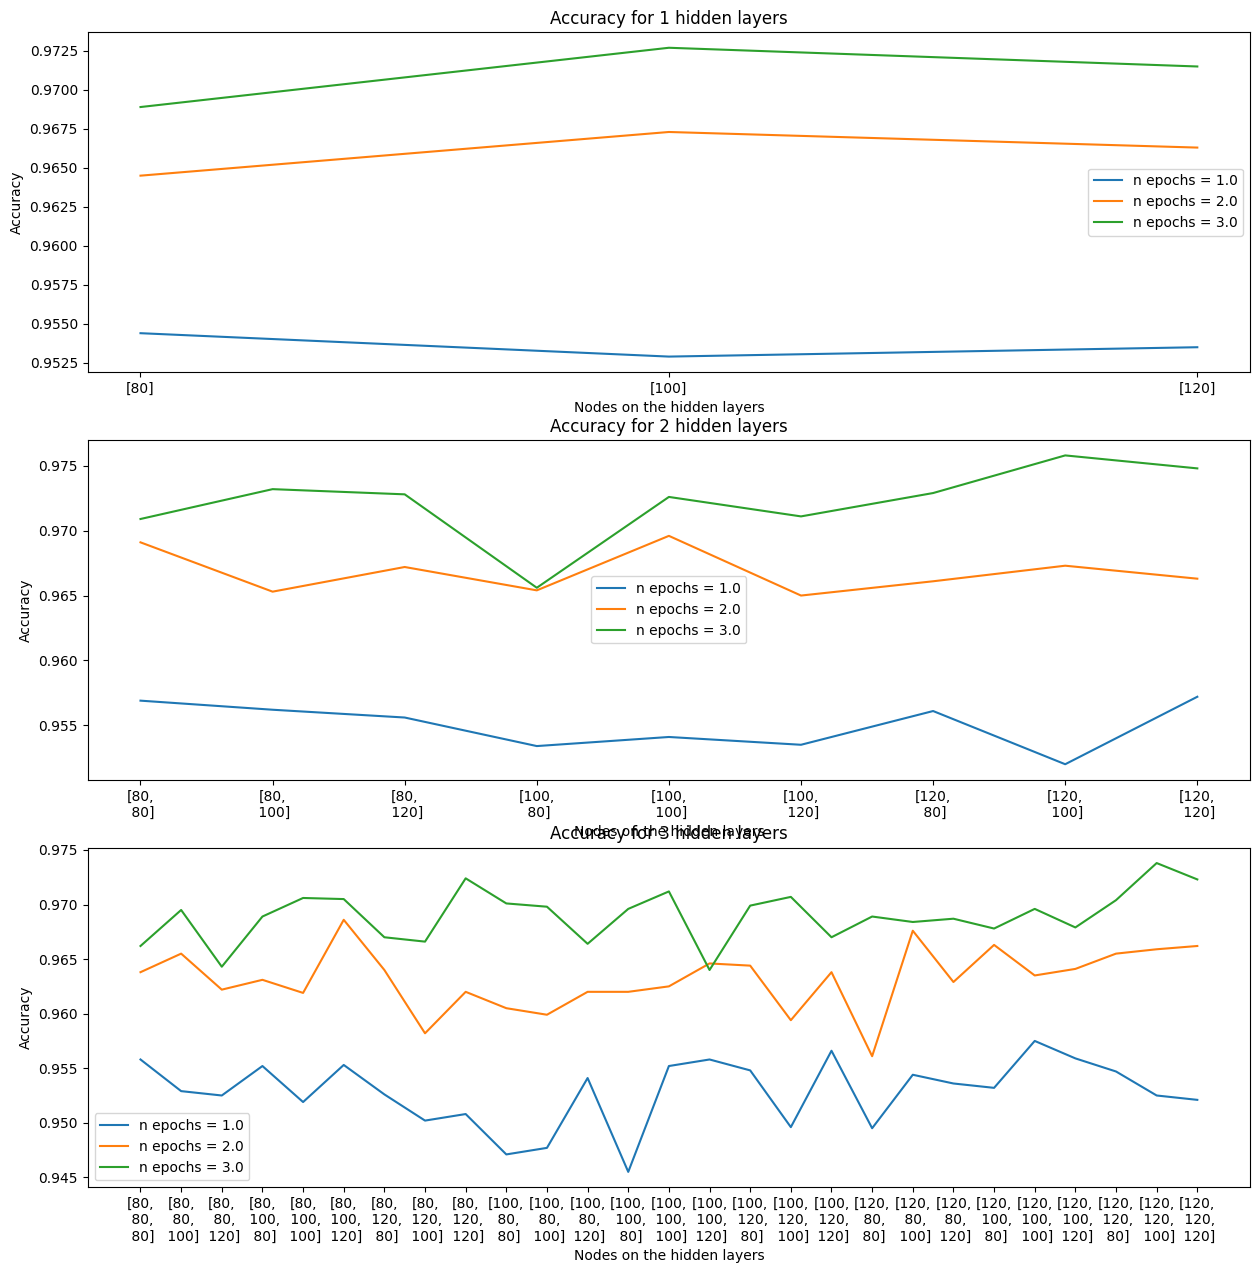

In [60]:
#gse_1

grid = "gse_1.pkl"
grid_path = Path.cwd() / "grid_searches" / grid
with open(grid_path, 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'ne')

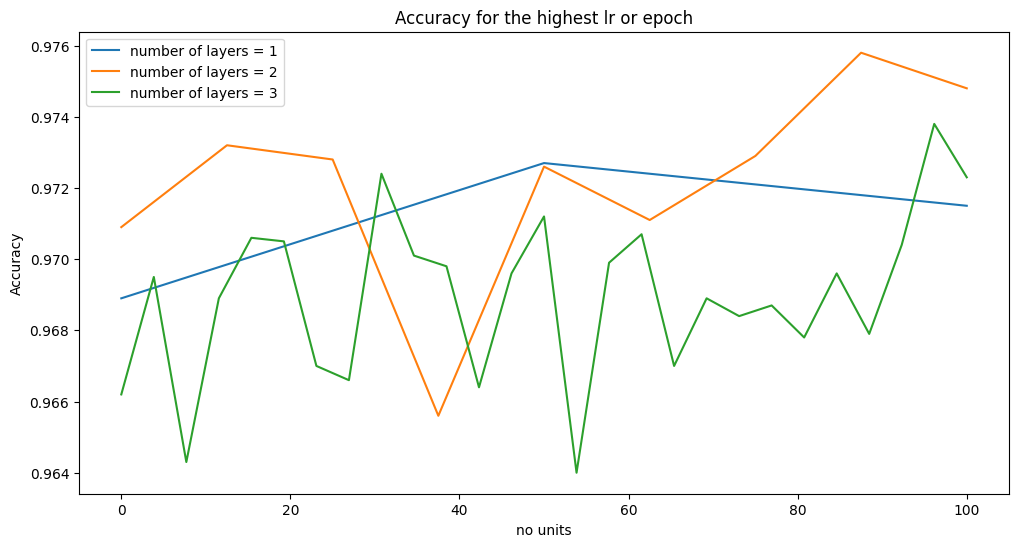

In [61]:
#gse_1
compare_lr_ne(accuracy_dict,[3,3,3])

In [62]:
print_best_models(accuracy_dict)

lr or ne 1.0 hidden layer nodes [80] accuracy 0.9544
lr or ne 2.0 hidden layer nodes [100] accuracy 0.9673
lr or ne 3.0 hidden layer nodes [100] accuracy 0.9727
lr or ne 1.0 hidden layer nodes [120, 120] accuracy 0.9572
lr or ne 2.0 hidden layer nodes [100, 100] accuracy 0.9696
lr or ne 3.0 hidden layer nodes [120, 100] accuracy 0.9758
lr or ne 1.0 hidden layer nodes [120, 100, 100] accuracy 0.9575
lr or ne 2.0 hidden layer nodes [80, 100, 120] accuracy 0.9686
lr or ne 3.0 hidden layer nodes [120, 120, 100] accuracy 0.9738


Now we see, as expected, that more training epochs bring higher accuracy across all networks, and not only that, but the 2 and 3 hidden layers networks start to outperform the 1 hidden layer network more often. 

Now for our final parameters we will try to increase the number of epochs and nodes to see if we can go a bit further. 

In [63]:
parameters = {'Learning_Rate': 0.01,
              'Number of  training epochs': [3,4,5],
              'Number of Hidden Layers': [1,2,3],
              'Number of nodes in a hidden layer': [120,150,180]
             }
#the total number of trials is      (assuming 1 epoch 1 trial, 2 epochs 2 trials)
#( sum_nhd (len(nn)^nhd) )* sum(nte)
#(3^1 + 3^2 + 3^3) * 12 = 468

In [64]:
#start = time.time()
#accuracy_dict = Grid_Search_epoch(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
#print('It took ', time.time()-start, ' seconds')

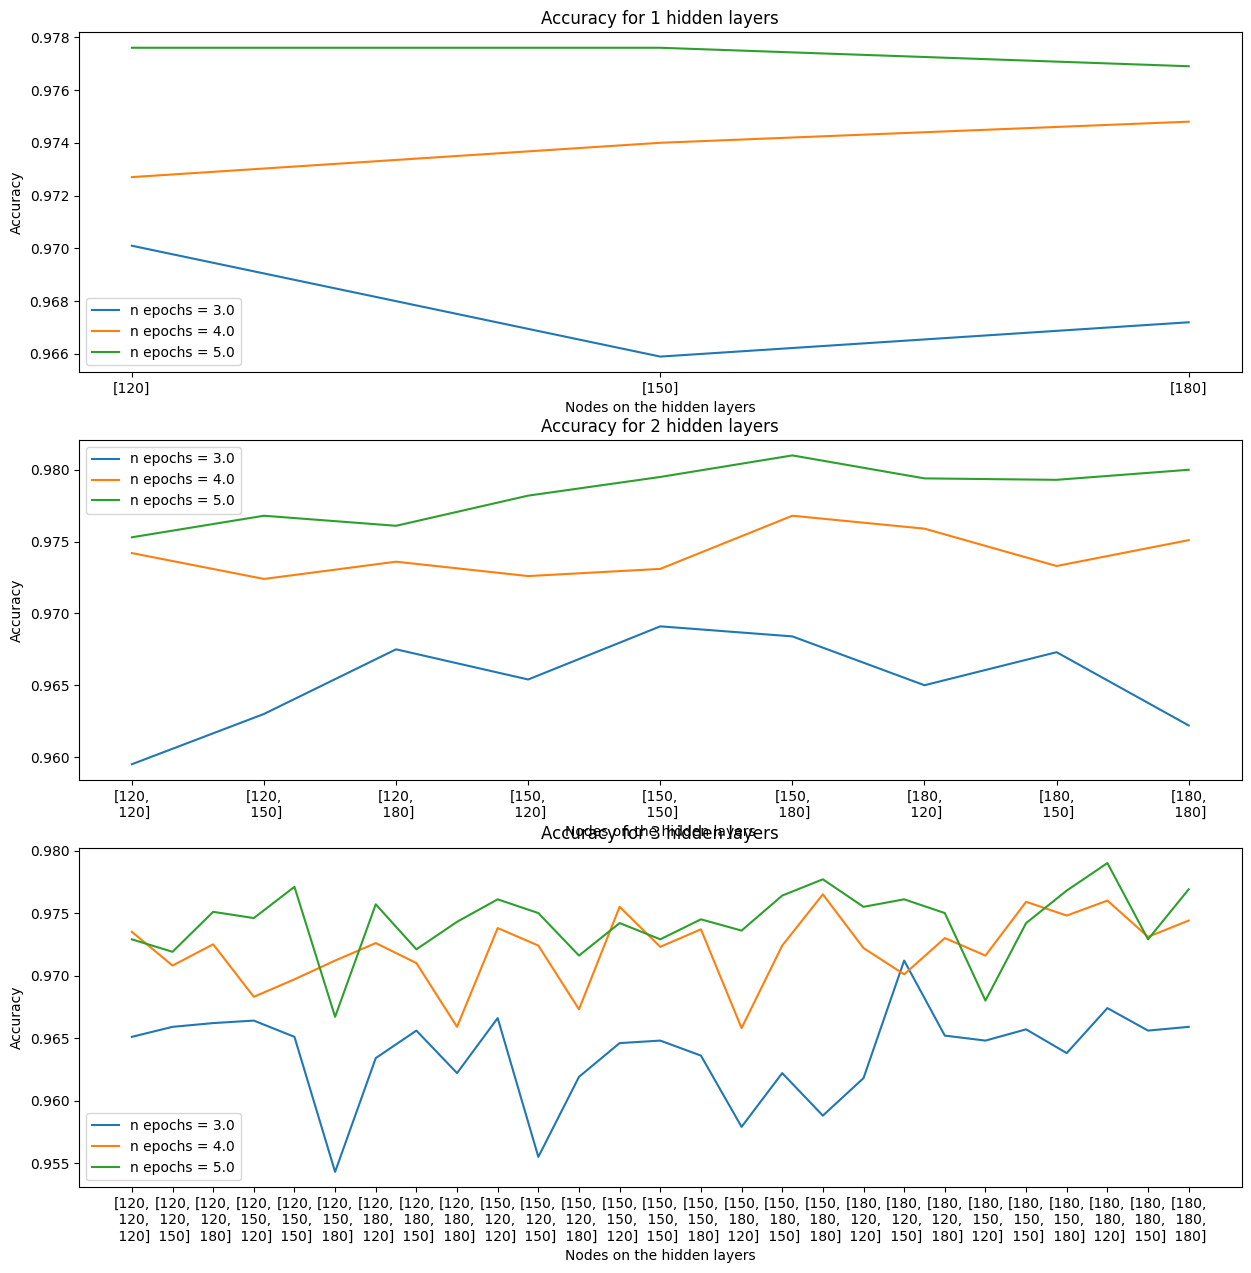

In [65]:
#gse_2

grid = "gse_2.pkl"
grid_path = Path.cwd() / "grid_searches" / grid
with open(grid_path, 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'ne')

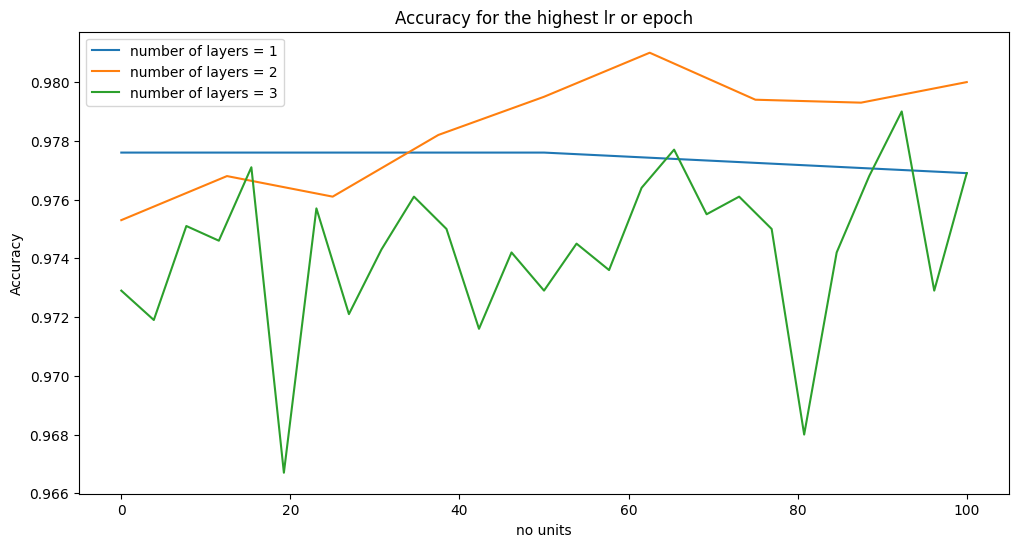

In [66]:
#gse_2
compare_lr_ne(accuracy_dict,[5,5,5])

We can see here that 2 layers seems to be performing the best. Additionally, 1 layer has reached a plateau.
Still, 2 and 3 layers still seem to be getting better as the number of nodes and training epochs increase, so we will do a final grid search with 2 and 3 layers, with higher epochs and number of nodes. 

In [67]:
#gse_2
print_best_models(accuracy_dict)

lr or ne 3.0 hidden layer nodes [120] accuracy 0.9701
lr or ne 4.0 hidden layer nodes [180] accuracy 0.9748
lr or ne 5.0 hidden layer nodes [120] accuracy 0.9776
lr or ne 3.0 hidden layer nodes [150, 150] accuracy 0.9691
lr or ne 4.0 hidden layer nodes [150, 180] accuracy 0.9768
lr or ne 5.0 hidden layer nodes [150, 180] accuracy 0.981
lr or ne 3.0 hidden layer nodes [180, 120, 150] accuracy 0.9712
lr or ne 4.0 hidden layer nodes [150, 180, 180] accuracy 0.9765
lr or ne 5.0 hidden layer nodes [180, 180, 120] accuracy 0.979


We can see that as of now, our best models are
- \[150,180] 5 epochs for an accuracy of 0.981
- \[180,180,120] 5 epochs for an accuracy of 0.979
- \[120] 5 epochs for an accuracy of 0.9776
- \[150,180] 4 epochs for an accuracy of 0.9768

The final grid search with 2 and 3 layers, with higher epochs and number of nodes will have parameters

In [68]:
parameters = {'Learning_Rate': 0.01,
              'Number of  training epochs': [6,7,8],
              'Number of Hidden Layers': [2,3],
              'Number of nodes in a hidden layer': [200,250,300]
             }
#the total number of trials is      (assuming 1 epoch 1 trial, 2 epochs 2 trials)
#( sum_nhd (len(nn)^nhd) )* sum(nte)
#(3^2 + 3^3) * 21 = 756

In [69]:
#start = time.time()
#accuracy_dict = Grid_Search_epoch(parameters,training_data[0],training_data[1],validation_data[0],validation_data[1])
#print('It took ', time.time()-start, ' seconds')

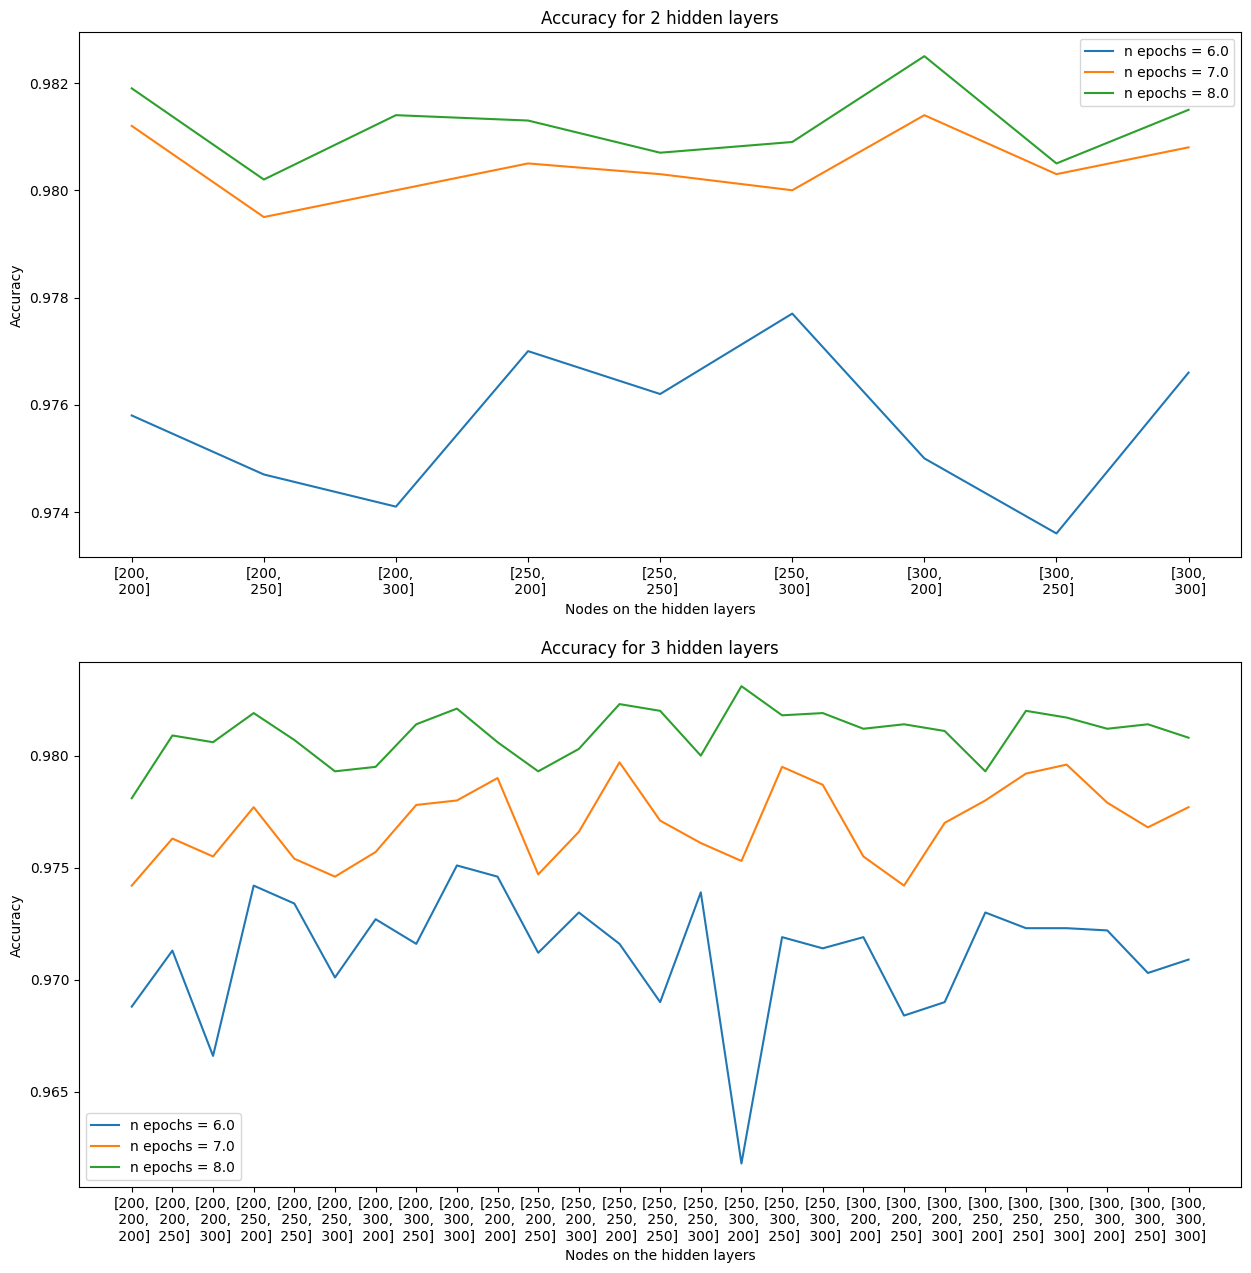

In [70]:
#gse_3

grid = "gse_3.pkl"
grid_path = Path.cwd() / "grid_searches" / grid
with open(grid_path, 'rb') as f:
    accuracy_dict, parameters = pickle.load(f)
disp_gs_results(accuracy_dict,'ne')

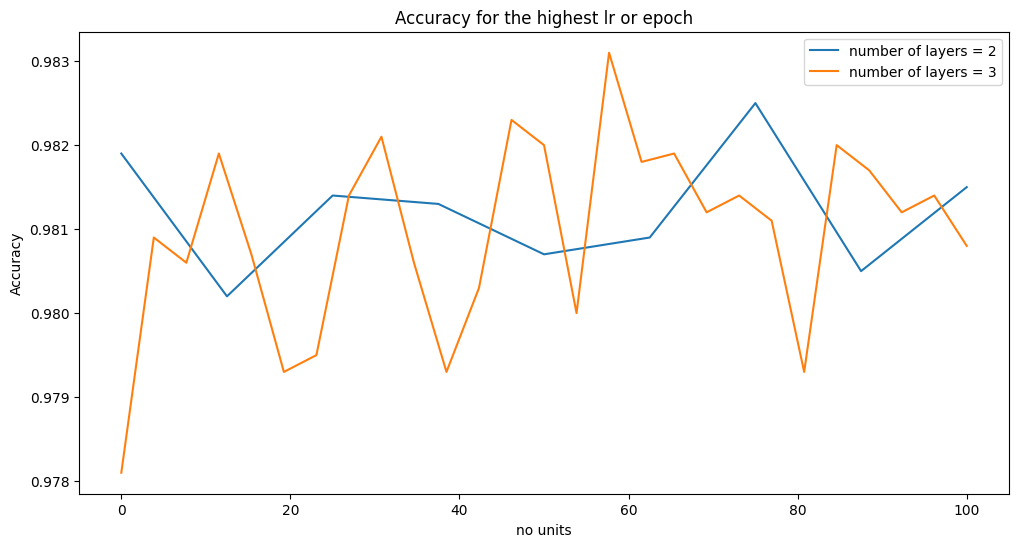

In [71]:
compare_lr_ne(accuracy_dict,[8,8])

Finally, we see that the accuracy has hit a maximum at least for the number of nodes or layers, and only seems to experience a slight increase when increasing the number of epochs. So we will finally decide on the best structure for our model. To make the best decision we will compare the best models of each grid search and choose. 

In [72]:
print_best_models(accuracy_dict)

lr or ne 6.0 hidden layer nodes [250, 300] accuracy 0.9777
lr or ne 7.0 hidden layer nodes [300, 200] accuracy 0.9814
lr or ne 8.0 hidden layer nodes [300, 200] accuracy 0.9825
lr or ne 6.0 hidden layer nodes [200, 300, 300] accuracy 0.9751
lr or ne 7.0 hidden layer nodes [250, 250, 200] accuracy 0.9797
lr or ne 8.0 hidden layer nodes [250, 300, 200] accuracy 0.9831


For gs_2
- \[80]     lr = 0.01 ne = 1 for an accuracy of 0.9589
- \[80, 60] lr = 0.01 ne = 1 for an accuracy of 0.9551

For gs_3
- \[80,120]     lr = 0.01 ne = 1 for an accuracy of 0.963 
- \[120]        lr = 0.01 ne = 1 for an accuracy of 0.9619
- \[120,120,80] lr = 0.01 ne = 1 for an accuracy of 0.9615

For gse_1
- \[120, 100]      lr = 0.01 ne = 3 accuracy 0.9758
- \[120, 120, 100] lr = 0.01 ne = 3 accuracy 0.9738
- \[100]           lr = 0.01 ne = 3 accuracy 0.9727


For gse_2
- \[150,180]     lr = 0.01 ne = 5 for an accuracy of 0.981
- \[180,180,120] lr = 0.01 ne = 5 for an accuracy of 0.979
- \[120]         lr = 0.01 ne = 5 for an accuracy of 0.9776
- \[150,180]     lr = 0.01 ne = 4 for an accuracy of 0.9768

For gse_3
- \[250, 300, 200] lr = 0.01 ne = 8 accuracy 0.9831
- \[300, 200]      lr = 0.01 ne = 8 accuracy 0.9825
- \[300, 200]      lr = 0.01 ne = 7 accuracy 0.9814


Now we will choose a few models and train them with a high number of epochs. The models will be

- \[120,100] 0.9758
- \[120] 0.9776
- \[150,180] 0.981
- \[250,300,200] 0.9831

And they were chosen based on a trade-off of number of nodes and performance. These models will be trained for a high number of epochs and we will finally choose the best among the four.

In [73]:
#Model 1 [120,100]
print('model 1 [120,100]')
perc_1 = Perceptron([784,120,100,10])
lr = 0.01
batch = 5
nepoch = 12
perc_1.train(training_data[0],training_data[1],lr,batch,nepoch)
acc1 = perc_1.accuracy(validation_data[0],validation_data[1])
print(acc1)

#Model 2 [120]
print('model 2 [120]')
perc_2 = Perceptron([784,120,10])
lr = 0.01
batch = 5
nepoch = 12
perc_2.train(training_data[0],training_data[1],lr,batch,nepoch)
acc2 = perc_2.accuracy(validation_data[0],validation_data[1])
print(acc2)

#Model 3 [150,180]
print('model 3 [150,180]')
perc_3 = Perceptron([784,150,180,10])
lr = 0.01
batch = 5
nepoch = 12
perc_3.train(training_data[0],training_data[1],lr,batch,nepoch)
acc3 = perc_3.accuracy(validation_data[0],validation_data[1])
print(acc3)

#Model 4 [250,300,200]
print('model 4 [250,300,200]')
perc_4 = Perceptron([784,250,300,200,10])
lr = 0.01
batch = 5
nepoch = 12
perc_4.train(training_data[0],training_data[1],lr,batch,nepoch)
acc4 = perc_4.accuracy(validation_data[0],validation_data[1])
print(acc4)

model 1 [120,100]
0.977
model 2 [120]
0.9773
model 3 [150,180]
0.9799
model 4 [250,300,200]
0.9781


We can see that there is some randomization in the values of the accuracy, so in this case, increasing the number of epochs did not bring an increase in performance. Seeing this, we will settle for \[120] as our best model, since it is faster to train and execute than bigger models, while having only slightly worse performance than the others. 

Ultimately, we have seen that our initial assumption that increasing the number of epochs would make all networks more accurate regardless of their size was mostly true, since we have not seen any indication that a bigger netowrk would suddenly start performing better as we increased the number of epochs. 

In [74]:
#Final model [120]
print('Model [120]')
perc_6 = Perceptron([784,120,10])

lr = 0.01
batch = 5
nepoch = 20
perc_6.train(training_data[0],training_data[1],lr,batch,nepoch)
acc6 = perc_6.accuracy(validation_data[0],validation_data[1])
print('ne ',nepoch,'acc ',acc6)

Model [120]
ne  20 acc  0.9773


In [75]:
perc_6.accuracy(test_data[0],test_data[1])

np.float64(0.9781)

Doing a final test we see that the accuracy is still around 98 even with the test data instead of the validation, so no overfittingtook place

In [77]:
def save_model(model,model_name):
    """Saves the model as a .pkl file
    
    Args: 
        model: the model object to be saved
        model_name: a string with the name of the model
    """
    #clean the model to remove unnecessary variables stored in it
    model.clean()
    model_name = model_name+".pkl"
    model_path = Path.cwd().parent / "models" / model_name
    if model_path.exists():
        yesno = input(f'the model {model_name} already exists, want to rewrite it? (y/n) ')
        if yesno == 'y':
            with open(model_path, 'wb') as f:
                pickle.dump(model,f)
            print(f"Model saved as {model_path}")
        else:
            print("Model not saved")
    else:
        with open(model_path, 'wb') as f:
            pickle.dump(model,f)
        print(f"Model saved as {model_path}")

In [78]:
def load_model(model_name):
    """Loads a model that has been saved as a .pkl file
    
    Args: 
        model_name: a string with the name of the model
    
    Returns: 
        the model object that has been loaded
    """
    model_name = model_name+".pkl"
    model_path = Path.cwd().parent / "models" / model_name
    with open(model_path,'rb') as f:
        model = pickle.load(f)
    
    return model

In [79]:
def saving_gs_results(acc_dict,parameters,filename):
    """Saves the grid search results as a .pkl file
    
    Args: 
        acc_dict: a list of dictionaries containing the results of the grid search
        parameters: the dicttionary of the parameters used for the grid search
        filename: the name of the file to be saved
    """
    filename = filename + ".pkl"
    file_path = Path.cwd() / "grid_searches" / filename

    if file_path.exists():
        yesno = input(f'the file {filename} already exists, want to rewrite it? (y/n) ')
        if yesno == 'y':
            with open(file_path, 'wb') as f:
                pickle.dump([acc_dict,parameters], f)
            print("File has been rewritten")
        else:
            print("File not rewritten")
    else:
        with open(file_path, 'wb') as f:
            pickle.dump([acc_dict,parameters], f)
        print(f"File saved as {file_path}")

#Getting back the objects:
#with open('/.../gs_2.pkl', 'rb') as f:
#    accuracy_dict, parameters = pickle.load(f)

In [ ]:
#save_model(perc_6, "perceptron_model")

Model saved as c:\Users\oriol\GitHub_Repos\Multi-layer-perceptron\models\perceptron_model.pkl


___